In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, length
from pyspark.sql.types import FloatType
import torch
from torch import nn
from sentence_transformers import SentenceTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import numpy as np
import os
import json
import warnings
import logging

warnings.filterwarnings('ignore')
logging.getLogger().setLevel(logging.ERROR)

spark = SparkSession.builder \
    .appName("Text_FakeReview") \
    .getOrCreate()

print("Spark version:", spark.version)

In [19]:
# Data Processing Functions
def create_fake_review_labels(df):
    """Enhanced fake review detection logic"""
    return df.withColumn(
        "label",
        when(
            (
                ((col("rating") == 5.0) & (col("helpful_vote") == 0)) |
                ((col("verified_purchase") == False) & (col("rating").isin([1.0, 5.0]))) |
                ((length(col("text")) < 20) & (col("rating").isin([1.0, 5.0])))
            ),
            1.0
        ).otherwise(0.0)
    )

class TextReviewClassifier(nn.Module):
    def __init__(self, bert_model="sentence-transformers/all-MiniLM-L6-v2"):
        super().__init__()
        self.text_encoder = SentenceTransformer(bert_model)
        self.classifier = nn.Linear(384, 2)

    def forward(self, text_list):
        # Get embeddings
        text_embeddings = self.text_encoder.encode(text_list, convert_to_tensor=True)
        logits = self.classifier(text_embeddings)
        return logits

def process_review(text, model):
    """Process single text review"""
    try:
        with torch.no_grad():
            logits = model([text])
            pred = torch.softmax(logits, dim=-1)
            return pred.numpy()
    except Exception as e:
        print(f"Error processing review: {str(e)}")
        return None

def save_results(results, output_path):
    """Save predictions as JSON"""
    with open(output_path, 'w') as f:
        json.dump(results, f)

def main():
    print("Fake review detection pipeline...")

    # Load data from HDFS
    hdfs_path = "hdfs://namenode:9000/output/cleaned_reviews"
    df = spark.read.parquet(hdfs_path).limit(200000)
    
    # Add fake review labels
    df = create_fake_review_labels(df)

    # Take small sample for testing
    sample_size = 1000
    reviews = df.filter(col("text").isNotNull()).collect()
    print(f"Processing {len(reviews)} reviews...")

    # Initialize model
    model = TextReviewClassifier()

    results = []
    counter = 0
    for row in reviews:
        pred = process_review(row.text, model)
        if pred is not None:
            results.append({
                "user_id": row.user_id,
                "asin": row.asin,
                "text_review": row.text[:100],  # truncated
                "prediction": pred.tolist(),
                "label": float(row.label)
            })
            counter += 1
            if counter % 50000 == 0:
                print(f"Processed {counter} reviews...", flush=True)
    print(f"\nProcessed {len(results)} reviews successfully")

    # Save results to HDFS
    if results:
        results_df = spark.createDataFrame(results)
        results_df.write.mode("overwrite").parquet("hdfs://namenode:9000/output/text_predictions")
        print(f"Saved {len(results)} processed reviews!")

        # Prepare lists
        y_true = [row['label'] for row in results]
        y_pred = [np.argmax(row['prediction'][0]) for row in results]  # predicted class
        y_probs = [row['prediction'][0][1] for row in results]  # probability of fake class
        
        # Compute metrics
        print("=== Evaluation Metrics ===")
        print("Accuracy:", accuracy_score(y_true, y_pred))
        print("Precision:", precision_score(y_true, y_pred))
        print("Recall:", recall_score(y_true, y_pred))
        print("F1-Score:", f1_score(y_true, y_pred))
        print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
        print("ROC-AUC:", roc_auc_score(y_true, y_probs))

        return y_true, y_pred, y_probs
    else:
        print("No reviews were successfully processed!")

if __name__ == "__main__":
    try:
        y_true, y_pred, y_probs = main()
    finally:
        spark.stop()


Fake review detection pipeline...
Processing 200000 reviews...
Processed 50000 reviews...
Processed 100000 reviews...
Processed 150000 reviews...
Processed 200000 reviews...

Processed 200000 reviews successfully
Saved 200000 processed reviews!
=== Evaluation Metrics ===
Accuracy: 0.49516
Precision: 0.49350225431992983
Recall: 0.9831335094492989
F1-Score: 0.6571405286463285
Confusion Matrix:
 [[ 2272 99308]
 [ 1660 96760]]
ROC-AUC: 0.514832225316728


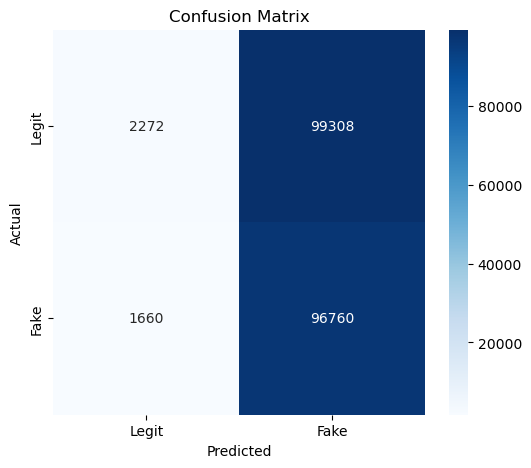

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Legit', 'Fake'], yticklabels=['Legit', 'Fake'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
